In [2]:
import pandas as pd
import json
import os

# --- Configuration ---
statsbomb_data_path = './data/'

# --- Data Loading (MODIFIED to load only a few files) ---
all_matches_data = []
# Set a limit for the number of files to load for testing
file_load_limit = 5 # <--- CHANGE THIS TO LOAD MORE OR FEWER FILES FOR TESTING

# Construct the path to the events for the specific competition and season
events_path = os.path.join(statsbomb_data_path, 'events')
print(f"Looking for event data in: {events_path}")

if not os.path.exists(events_path):
    print(f"Error: Path not found. Please verify `statsbomb_data_path` and ensure the 'events' folder exists within it.")
    print(f"Current working directory: {os.getcwd()}")
else:
    files_to_load = []
    # Collect list of JSON files
    for file_name in os.listdir(events_path):
        if file_name.endswith('.json'):
            files_to_load.append(file_name)

    # Process only a limited number of files
    print(f"Attempting to load the first {file_load_limit} JSON files...")
    for i, file_name in enumerate(files_to_load):
        if i >= file_load_limit:
            print(f"Reached load limit of {file_load_limit} files. Stopping.")
            break # Stop after loading the limit

        file_path = os.path.join(events_path, file_name)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                match_events = json.load(f)
                match_id = file_name.replace('.json', '')
                for event in match_events:
                    event['match_id'] = match_id
                all_matches_data.extend(match_events)
            print(f"Loaded events from: {file_name}")
        except Exception as e:
            print(f"Error loading {file_name}: {e}")

# Convert the list of event dictionaries to a Pandas DataFrame
if all_matches_data:
    df_events = pd.DataFrame(all_matches_data)
    print("\nAll match events combined successfully!")
    print(f"Total events loaded: {len(df_events)}")
else:
    print("\nNo event data loaded. Please check the path and file structure.")
    df_events = pd.DataFrame() # Create empty DataFrame to avoid errors

# --- Initial Data Inspection ---
print("\nFirst 5 rows of the events DataFrame:")
print(df_events.head())

print("\nDataFrame Info:")
df_events.info()

print("\nBasic descriptive statistics (if applicable):")
print(df_events.describe(include='all'))

print("\nUnique Event Types (Top 10):")
print(df_events['type.name'].value_counts().head(10))

print("\nUnique Player Positions (Top 10):")
if 'position' in df_events.columns:
    print(df_events['position'].apply(lambda x: x['name'] if isinstance(x, dict) and 'name' in x else None).value_counts().head(10))
else:
    print(" 'position' column not found or not in expected format.")

print("\nShape of the consolidated events DataFrame (rows, columns):", df_events.shape)

Looking for event data in: ./data/events
Attempting to load the first 5 JSON files...
Loaded events from: 3879600.json
Loaded events from: 3901250.json
Loaded events from: 3754300.json
Loaded events from: 2275050.json
Loaded events from: 19795.json
Reached load limit of 5 files. Stopping.

All match events combined successfully!
Total events loaded: 16606

First 5 rows of the events DataFrame:
                                     id  index  period     timestamp  minute  \
0  7735799b-6354-44fe-a229-64b8a67a969f      1       1  00:00:00.000       0   
1  652704d3-ee12-4a30-9339-8b004546b869      2       1  00:00:00.000       0   
2  fc979483-b7ba-46b0-8683-7635fb60c6e6      3       1  00:00:00.000       0   
3  3955c5cc-64a8-4256-8bcf-db9af22753f2      4       1  00:00:00.000       0   
4  96f97982-f193-4a6c-916b-acea383c8f5c      5       1  00:00:01.895       0   

   second                               type  possession  \
0       0  {'id': 35, 'name': 'Starting XI'}           1   
1 

KeyError: 'type.name'

In [4]:
import pandas as pd
import numpy as np # Already imported, but good to keep it for this block
# Make sure df_events is loaded from the previous step

# --- Phase 2: Data Preparation & Flattening ---
print("Starting data preparation and flattening...")

# 1. Flattening Nested Columns
# We'll create new, direct columns for key nested information.

# Event Type Name
df_events['event_type'] = df_events['type'].apply(lambda x: x['name'] if isinstance(x, dict) else None)

# Possession Team Name
df_events['possession_team_name'] = df_events['possession_team'].apply(lambda x: x['name'] if isinstance(x, dict) else None)

# Team Name
df_events['team_name'] = df_events['team'].apply(lambda x: x['name'] if isinstance(x, dict) else None)

# Player Name
df_events['player_name'] = df_events['player'].apply(lambda x: x['name'] if isinstance(x, dict) else None)

# Player Position (if exists and is a dict)
df_events['player_position_name'] = df_events['position'].apply(lambda x: x['name'] if isinstance(x, dict) and 'name' in x else None)

# Location coordinates (x, y)
# Location is a list [x, y], so we need to extract them
df_events['location_x'] = df_events['location'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan)
df_events['location_y'] = df_events['location'].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else np.nan)

# Timestamp conversion to datetime for easier analysis
df_events['datetime'] = pd.to_datetime(df_events['timestamp'])

# --- Handle specific event details (e.g., pass, shot) which are also nested ---

# For 'Pass' events: get recipient, outcome, and type
# Check if 'pass' column exists and is a dict before accessing sub-keys
df_events['pass_recipient_name'] = df_events['pass'].apply(
    lambda x: x['recipient']['name'] if isinstance(x, dict) and 'recipient' in x and isinstance(x['recipient'], dict) else None
)
df_events['pass_outcome_name'] = df_events['pass'].apply(
    lambda x: x['outcome']['name'] if isinstance(x, dict) and 'outcome' in x and isinstance(x['outcome'], dict) else 'Complete' # Assume complete if no outcome specified
)
df_events['pass_length'] = df_events['pass'].apply(
    lambda x: x['length'] if isinstance(x, dict) and 'length' in x else np.nan
)
df_events['pass_angle'] = df_events['pass'].apply(
    lambda x: x['angle'] if isinstance(x, dict) and 'angle' in x else np.nan
)
df_events['pass_end_location_x'] = df_events['pass'].apply(
    lambda x: x['end_location'][0] if isinstance(x, dict) and 'end_location' in x and isinstance(x['end_location'], list) else np.nan
)
df_events['pass_end_location_y'] = df_events['pass'].apply(
    lambda x: x['end_location'][1] if isinstance(x, dict) and 'end_location' in x and isinstance(x['end_location'], list) else np.nan
)

# For 'Shot' events: get outcome, xG, and shot type
df_events['shot_outcome_name'] = df_events['shot'].apply(
    lambda x: x['outcome']['name'] if isinstance(x, dict) and 'outcome' in x and isinstance(x['outcome'], dict) else None
)
df_events['shot_statsbomb_xg'] = df_events['shot'].apply(
    lambda x: x['statsbomb_xg'] if isinstance(x, dict) and 'statsbomb_xg' in x else np.nan
)
df_events['shot_type_name'] = df_events['shot'].apply(
    lambda x: x['shot_type']['name'] if isinstance(x, dict) and 'shot_type' in x and isinstance(x['shot_type'], dict) else None
)

print("Flattening complete. New columns created.")

# 2. Select Relevant Columns & Drop Original Nested Ones
# We'll keep the original columns for now to ensure we don't miss anything,
# but for cleaner analysis, we'll select the flat ones.
# You can customize this list based on what aspects of tactical analysis you want to focus on.
# For now, let's keep the most common and useful ones.

selected_columns = [
    'match_id', 'id', 'period', 'timestamp', 'minute', 'second', 'datetime',
    'event_type', 'possession', 'possession_team_name', 'play_pattern', 'team_name',
    'player_name', 'player_position_name', 'location_x', 'location_y',
    'pass_recipient_name', 'pass_outcome_name', 'pass_length', 'pass_angle',
    'pass_end_location_x', 'pass_end_location_y',
    'shot_outcome_name', 'shot_statsbomb_xg', 'shot_type_name'
]

# Create a new DataFrame with only the selected columns (and drop NaNs for location, player, team)
df_flat_events = df_events[selected_columns].copy()

# Drop rows where essential information is missing (e.g., location, player, team name for analysis)
original_rows_flat = df_flat_events.shape[0]
df_flat_events.dropna(subset=['location_x', 'location_y', 'player_name', 'team_name', 'event_type'], inplace=True)
rows_after_dropping_flat = df_flat_events.shape[0]
print(f"Dropped {original_rows_flat - rows_after_dropping_flat} rows with essential missing data in flat DF.")
print(f"Remaining rows in flat DF: {rows_after_dropping_flat}")

print("\nData preparation and flattening complete!")

# --- Initial Inspection of the Flattened DataFrame ---
print("\nFirst 5 rows of the FLATTENED events DataFrame:")
print(df_flat_events.head())

print("\nFlattened DataFrame Info:")
df_flat_events.info()

print("\nUnique Event Types (FLATTENED - Top 10):")
print(df_flat_events['event_type'].value_counts().head(10))

print("\nUnique Team Names (FLATTENED - Top 10):")
print(df_flat_events['team_name'].value_counts().head(10))

print("\nShape of the FLATTENED events DataFrame (rows, columns):", df_flat_events.shape)

Starting data preparation and flattening...


/var/folders/yj/j49r0dj531d9qkzctpgyc39c0000gn/T/ipykernel_17183/208420795.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_events['datetime'] = pd.to_datetime(df_events['timestamp'])


Flattening complete. New columns created.
Dropped 141 rows with essential missing data in flat DF.
Remaining rows in flat DF: 16465

Data preparation and flattening complete!

First 5 rows of the FLATTENED events DataFrame:
  match_id                                    id  period     timestamp  \
4  3879600  96f97982-f193-4a6c-916b-acea383c8f5c       1  00:00:01.895   
5  3879600  c3d6e190-77c0-44a2-84c1-8fcf2b647680       1  00:00:02.263   
6  3879600  f26a0925-171d-462f-b572-2850df955a3b       1  00:00:02.263   
7  3879600  cde2c3d5-2391-4016-aa19-7115b7ced125       1  00:00:02.653   
8  3879600  f0f511ea-2760-49b1-b8d0-35c5b8a4d1bf       1  00:00:03.335   

   minute  second                datetime     event_type  possession  \
4       0       1 2025-06-10 00:00:01.895           Pass           2   
5       0       2 2025-06-10 00:00:02.263  Ball Receipt*           2   
6       0       2 2025-06-10 00:00:02.263          Carry           2   
7       0       2 2025-06-10 00:00:02.653  

Starting tactical feature engineering and analysis...

Generating Shot Map for all loaded matches...


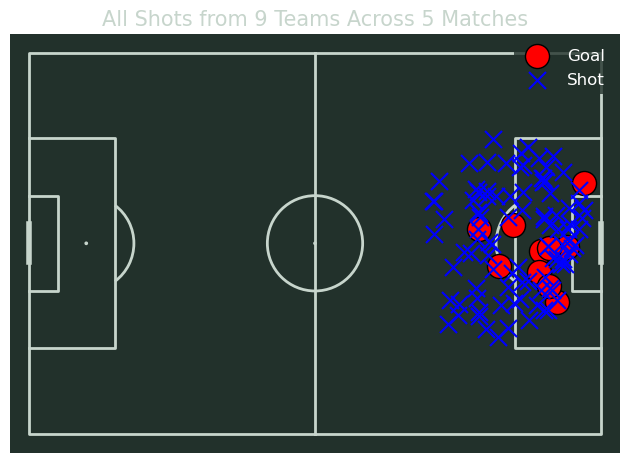


Calculating Pass Completion Rates by Team...
Pass Outcomes Distribution:
 pass_outcome_name
Complete            3132
Incomplete          1122
Out                  124
Unknown               31
Pass Offside          23
Injury Clearance      10
Name: count, dtype: int64

Team Pass Completion Rates:
pass_outcome_name    Complete  Completion_Rate
team_name                                     
OGC Nice             0.847716        84.771574
Everton              0.785714        78.571429
Hellas Verona        0.752896        75.289575
Saint-Étienne        0.685460        68.545994
Watford              0.680912        68.091168
Reading WFC          0.675589        67.558887
Carpi                0.621701        62.170088
Birmingham City WFC  0.598958        59.895833
West Ham United LFC  0.561404        56.140351

Building Passing Network for Match ID: 3754300


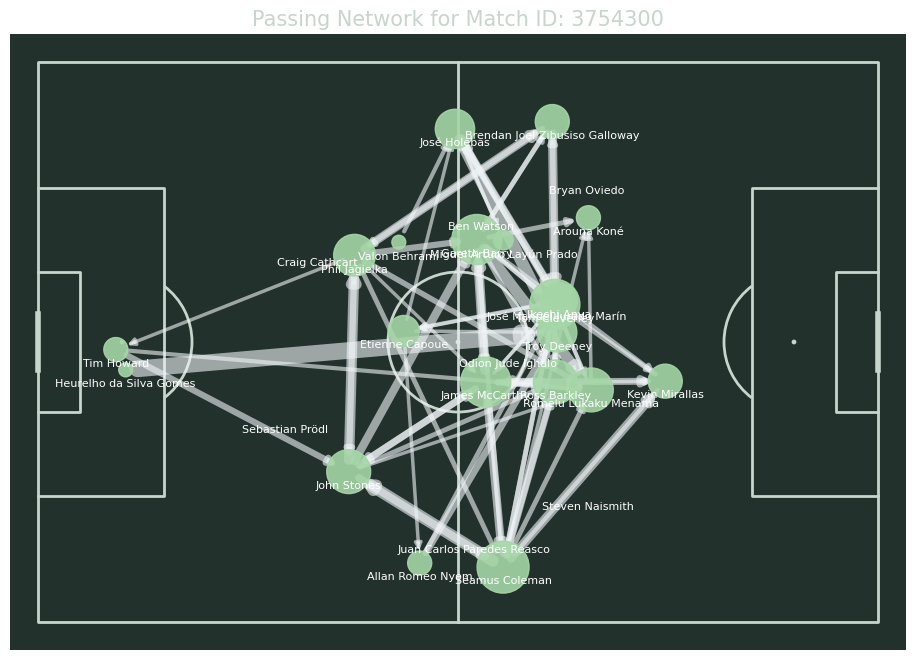


Tactical feature engineering and analysis complete!


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import Pitch, VerticalPitch, FontManager
import networkx as nx

print("Starting tactical feature engineering and analysis...")

# --- 1. Coordinate System Standardization (StatsBomb is 120x80) ---
PITCH_LENGTH = 120
PITCH_WIDTH = 80

# --- 2. Basic Event Distribution: Shot Map (All shots in the loaded matches) ---
print("\nGenerating Shot Map for all loaded matches...")
df_shots = df_flat_events[df_flat_events['event_type'] == 'Shot'].copy()

if not df_shots.empty:
    pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
    fig, ax = pitch.draw()

    pitch.scatter(df_shots[df_shots['shot_outcome_name'] == 'Goal']['location_x'],
                  df_shots[df_shots['shot_outcome_name'] == 'Goal']['location_y'],
                  s=300, color='red', edgecolors='black', marker='o', label='Goal', ax=ax)

    pitch.scatter(df_shots[df_shots['shot_outcome_name'] != 'Goal']['location_x'],
                  df_shots[df_shots['shot_outcome_name'] != 'Goal']['location_y'],
                  s=150, color='blue', edgecolors='black', marker='x', label='Shot', ax=ax)

    ax.set_title(f'All Shots from {df_shots["team_name"].nunique()} Teams Across {df_shots["match_id"].nunique()} Matches', fontsize=15, color='#c7d5cc')
    ax.legend(facecolor='#22312b', edgecolor='None', fontsize=12, labelcolor='white')
    plt.savefig('./images/shot_map.png', bbox_inches='tight', dpi=300) # SAVES THE SHOT MAP
    plt.show()
else:
    print("No shot events found in the loaded data for plotting.")


# --- 3. Pass Analysis (Example: Pass Completion Rate) ---
print("\nCalculating Pass Completion Rates by Team...")
df_passes = df_flat_events[df_flat_events['event_type'] == 'Pass'].copy()

if not df_passes.empty:
    pass_outcomes = df_passes['pass_outcome_name'].value_counts()
    print("Pass Outcomes Distribution:\n", pass_outcomes)

    team_pass_summary = df_passes.groupby('team_name')['pass_outcome_name'].value_counts(normalize=True).unstack(fill_value=0)
    team_pass_summary['Completion_Rate'] = team_pass_summary['Complete'] * 100
    print("\nTeam Pass Completion Rates:")
    print(team_pass_summary[['Complete', 'Completion_Rate']].sort_values(by='Completion_Rate', ascending=False))

    # --- 4. Passing Networks (for a specific match) ---
    match_id_for_network = df_passes['match_id'].value_counts().index[0] # Pick the match with most passes
    print(f"\nBuilding Passing Network for Match ID: {match_id_for_network}")

    df_match_passes = df_passes[df_passes['match_id'] == match_id_for_network].copy()

    pass_connections = df_match_passes.groupby(['player_name', 'pass_recipient_name']).size().reset_index(name='num_passes')
    pass_connections = pass_connections[pass_connections['num_passes'] >= 5]

    player_positions = df_match_passes.groupby('player_name')[['location_x', 'location_y']].mean().reset_index()

    G = nx.DiGraph()

    for idx, row in player_positions.iterrows():
        G.add_node(row['player_name'], pos=(row['location_x'], row['location_y']))

    for idx, row in pass_connections.iterrows():
        if row['player_name'] in G and row['pass_recipient_name'] in G:
            G.add_edge(row['player_name'], row['pass_recipient_name'], weight=row['num_passes'])

    if G.nodes and G.edges:
        pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
        fig, ax = pitch.draw(figsize=(12, 8), constrained_layout=False, tight_layout=False)

        node_pos = nx.get_node_attributes(G, 'pos')
        node_sizes = [G.degree(node) * 100 for node in G.nodes()]
        nx.draw_networkx_nodes(G, node_pos, node_size=node_sizes, node_color='#a5d6a7', ax=ax, alpha=0.9)

        edge_widths = [d['weight'] / 2 for (u, v, d) in G.edges(data=True)]
        nx.draw_networkx_edges(G, node_pos, width=edge_widths, edge_color='#f0f4f7', arrows=True, ax=ax, alpha=0.6)

        labels_pos = {p: (pos[0], pos[1] + 2) for p, pos in node_pos.items()}
        nx.draw_networkx_labels(G, labels_pos, font_size=8, font_color='white', ax=ax)

        ax.set_title(f'Passing Network for Match ID: {match_id_for_network}', fontsize=15, color='#c7d5cc')
        plt.savefig('./images/passing_network.png', bbox_inches='tight', dpi=300) # SAVES THE PASSING NETWORK
        plt.show()
    else:
        print(f"Not enough significant passing connections (>=5 passes) to draw a network for Match ID: {match_id_for_network}")
else:
    print("No pass events found in the loaded data for analysis.")

print("\nTactical feature engineering and analysis complete!")

In [12]:
import pandas as pd
# Assuming df_flat_events is loaded from previous steps

print("\n--- Fun Facts from the Pitch! ---")

# 1. The Pass Master: Who made the most passes across these matches?
df_passes = df_flat_events[df_flat_events['event_type'] == 'Pass'].copy()
if not df_passes.empty:
    most_passes_player = df_passes['player_name'].value_counts().idxmax()
    num_passes = df_passes['player_name'].value_counts().max()
    print(f"🥇 **The Ultimate Pass Master:** '{most_passes_player}' (with {num_passes} passes!)")
else:
    print("Could not determine pass master (no pass events).")


# 2. The Shot Taker: Who attempted the most shots?
df_shots = df_flat_events[df_flat_events['event_type'] == 'Shot'].copy()
if not df_shots.empty:
    most_shots_player = df_shots['player_name'].value_counts().idxmax()
    num_shots = df_shots['player_name'].value_counts().max()
    print(f"🎯 **The Most Prolific Shooter:** '{most_shots_player}' (with {num_shots} shots attempted!)")
else:
    print("Could not determine prolific shooter (no shot events).")


# 3. The Most Common Reason for an Incomplete Pass (beyond just 'Incomplete'):
# Filter for passes that were NOT complete
df_incomplete_passes = df_passes[df_passes['pass_outcome_name'] != 'Complete'].copy()
if not df_incomplete_passes.empty:
    # Check if there are specific outcome types beyond just 'Incomplete'
    if df_incomplete_passes['pass_outcome_name'].nunique() > 1:
        most_common_failure = df_incomplete_passes['pass_outcome_name'].value_counts().idxmax()
        count_failure = df_incomplete_passes['pass_outcome_name'].value_counts().max()
        print(f"📉 **Top Pass Blunder:** The most common specific reason for an incomplete pass was '{most_common_failure}' ({count_failure} times).")
    else:
        print("Most incomplete passes are just generally 'Incomplete', no specific top blunder type found.")
else:
    print("No incomplete pass events found.")


# 4. The Defensive Wall: Who made the most ball recoveries?
df_ball_recoveries = df_flat_events[df_flat_events['event_type'] == 'Ball Recovery'].copy()
if not df_ball_recoveries.empty:
    top_recoverer = df_ball_recoveries['player_name'].value_counts().idxmax()
    num_recoveries = df_ball_recoveries['player_name'].value_counts().max()
    print(f"🛡️ **The Unsung Hero (Ball Recovery):** '{top_recoverer}' (with {num_recoveries} ball recoveries!)")
else:
    print("Could not determine top ball recoverer (no ball recovery events).")


# 5. Team with the Highest Average xG per Shot (a measure of shot quality)
# xG is Expected Goals, a measure of how likely a shot is to result in a goal.
df_shots_with_xg = df_flat_events[df_flat_events['shot_statsbomb_xg'].notna()].copy()
if not df_shots_with_xg.empty:
    team_avg_xg = df_shots_with_xg.groupby('team_name')['shot_statsbomb_xg'].mean().idxmax()
    avg_xg_value = df_shots_with_xg.groupby('team_name')['shot_statsbomb_xg'].mean().max()
    print(f"🔥 **Best Chance Creators:** The team with the highest average shot quality (xG per shot) was '{team_avg_xg}' (average xG: {avg_xg_value:.3f}).")
else:
    print("Could not calculate average xG (no shots with xG data).")


print("\n--- End of Fun Facts ---")


--- Fun Facts from the Pitch! ---
🥇 **The Ultimate Pass Master:** 'Josanne Potter' (with 125 passes!)
🎯 **The Most Prolific Shooter:** 'Fara Williams' (with 9 shots attempted!)
📉 **Top Pass Blunder:** The most common specific reason for an incomplete pass was 'Incomplete' (1122 times).
🛡️ **The Unsung Hero (Ball Recovery):** 'Josanne Potter' (with 15 ball recoveries!)
🔥 **Best Chance Creators:** The team with the highest average shot quality (xG per shot) was 'OGC Nice' (average xG: 0.113).

--- End of Fun Facts ---


In [14]:
import os

# Create 'images' directory if it doesn't exist
if not os.path.exists('images'):
    os.makedirs('images')
    print("Created 'images' directory.")
else:
    print("'images' directory already exists.")

Created 'images' directory.


In [18]:
import pandas as pd
# Assuming df_flat_events is loaded from previous steps

print("\n--- Fun Facts from the Pitch! ---")

# 1. The Pass Master: Who made the most passes across these matches?
df_passes = df_flat_events[df_flat_events['event_type'] == 'Pass'].copy()
if not df_passes.empty:
    most_passes_player = df_passes['player_name'].value_counts().idxmax()
    num_passes = df_passes['player_name'].value_counts().max()
    print(f"🥇 **The Ultimate Pass Master:** '{most_passes_player}' (with {num_passes} passes!)")
else:
    print("Could not determine pass master (no pass events).")


# 2. The Shot Taker: Who attempted the most shots?
df_shots = df_flat_events[df_flat_events['event_type'] == 'Shot'].copy()
if not df_shots.empty:
    most_shots_player = df_shots['player_name'].value_counts().idxmax()
    num_shots = df_shots['player_name'].value_counts().max()
    print(f"🎯 **The Most Prolific Shooter:** '{most_shots_player}' (with {num_shots} shots attempted!)")
else:
    print("Could not determine prolific shooter (no shot events).")


# 3. The Most Common Reason for an Incomplete Pass (beyond just 'Incomplete'):
# Filter for passes that were NOT complete
df_incomplete_passes = df_passes[df_passes['pass_outcome_name'] != 'Complete'].copy()
if not df_incomplete_passes.empty:
    # Check if there are specific outcome types beyond just 'Incomplete'
    if df_incomplete_passes['pass_outcome_name'].nunique() > 1:
        most_common_failure = df_incomplete_passes['pass_outcome_name'].value_counts().idxmax()
        count_failure = df_incomplete_passes['pass_outcome_name'].value_counts().max()
        print(f"📉 **Top Pass Blunder:** The most common specific reason for an incomplete pass was '{most_common_failure}' ({count_failure} times).")
    else:
        print("Most incomplete passes are just generally 'Incomplete', no specific top blunder type found.")
else:
    print("No incomplete pass events found.")


# 4. The Defensive Wall: Who made the most ball recoveries?
df_ball_recoveries = df_flat_events[df_flat_events['event_type'] == 'Ball Recovery'].copy()
if not df_ball_recoveries.empty:
    top_recoverer = df_ball_recoveries['player_name'].value_counts().idxmax()
    num_recoveries = df_ball_recoveries['player_name'].value_counts().max()
    print(f"🛡️ **The Unsung Hero (Ball Recovery):** '{top_recoverer}' (with {num_recoveries} ball recoveries!)")
else:
    print("Could not determine top ball recoverer (no ball recovery events).")


# 5. Team with the Highest Average xG per Shot (a measure of shot quality)
# xG is Expected Goals, a measure of how likely a shot is to result in a goal.
df_shots_with_xg = df_flat_events[df_flat_events['shot_statsbomb_xg'].notna()].copy()
if not df_shots_with_xg.empty:
    team_avg_xg = df_shots_with_xg.groupby('team_name')['shot_statsbomb_xg'].mean().idxmax()
    avg_xg_value = df_shots_with_xg.groupby('team_name')['shot_statsbomb_xg'].mean().max()
    print(f"🔥 **Best Chance Creators:** The team with the highest average shot quality (xG per shot) was '{team_avg_xg}' (average xG: {avg_xg_value:.3f}).")
else:
    print("Could not calculate average xG (no shots with xG data).")


print("\n--- End of Fun Facts ---")


--- Fun Facts from the Pitch! ---
🥇 **The Ultimate Pass Master:** 'Josanne Potter' (with 125 passes!)
🎯 **The Most Prolific Shooter:** 'Fara Williams' (with 9 shots attempted!)
📉 **Top Pass Blunder:** The most common specific reason for an incomplete pass was 'Incomplete' (1122 times).
🛡️ **The Unsung Hero (Ball Recovery):** 'Josanne Potter' (with 15 ball recoveries!)
🔥 **Best Chance Creators:** The team with the highest average shot quality (xG per shot) was 'OGC Nice' (average xG: 0.113).

--- End of Fun Facts ---
